# Impact of Covid-19 - Geographic Visualization

In this notebook, I visualized the data in raw_data.csv by bringing up interactive plots with plotly and geographical plots with geoplot.

This data set contains 170 countries' data with respect to the impact of covid-19 on the global economy.

In particular, the following three indicators are used to show the policy and economic situation of each countries.

1. [Stringency Index](https://data.humdata.org/dataset/oxford-covid-19-government-response-tracker): The score systematically collected information on several different common policy responses governments have taken, measured and aggregated.

1. gdp_per_capita: Gross Domestic Product (GDP) per capita.

1. [human_development_index](https://en.wikipedia.org/wiki/Human_Development_Index): Composite statistic of life expectancy, education, literacy and income indices used to rank countries into four stages of human development.

For those of you who are interested in this dataset, I will provide an overview of the data and examples of analysis using lineplot and geographical plot.

## Load libraries and data

In [1]:
from datetime import datetime as dt
import os
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import geoplot as gplt
import mapclassify
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import re
import seaborn as sns

In [2]:
!ls ../input/impact-of-covid19-pandemic-on-the-global-economy

raw_data.csv  transformed_data.csv


In [3]:
raw_data = pd.read_csv("../input/impact-of-covid19-pandemic-on-the-global-economy/raw_data.csv")
#There are some meaningless columns.
cols = ["iso_code", "location", "date", "total_cases", "total_deaths", "stringency_index", "population", "gdp_per_capita", "human_development_index"]
raw_data = raw_data[cols]

# Data overview

Let's see data overview.

In [4]:
raw_data.head()

,iso_code,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,human_development_index
0,AFG,Afghanistan,2019-12-31,0.0,0.0,0.0,38928341,1803.987,0.498
1,AFG,Afghanistan,2020-01-01,0.0,0.0,0.0,38928341,1803.987,0.498
2,AFG,Afghanistan,2020-01-02,0.0,0.0,0.0,38928341,1803.987,0.498
3,AFG,Afghanistan,2020-01-03,0.0,0.0,0.0,38928341,1803.987,0.498
4,AFG,Afghanistan,2020-01-04,0.0,0.0,0.0,38928341,1803.987,0.498


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50418 entries, 0 to 50417
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   iso_code                 50418 non-null  object 
 1   location                 50418 non-null  object 
 2   date                     50418 non-null  object 
 3   total_cases              47324 non-null  float64
 4   total_deaths             39228 non-null  float64
 5   stringency_index         43292 non-null  float64
 6   population               50418 non-null  int64  
 7   gdp_per_capita           44706 non-null  float64
 8   human_development_index  44216 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 3.5+ MB


In [6]:
raw_data.describe()

,total_cases,total_deaths,stringency_index,population,gdp_per_capita,human_development_index
count,4.732400e+04,39228.000000,43292.000000,5.041800e+04,44706.000000,44216.000000
mean,6.621927e+04,2978.767819,56.162022,4.251601e+07,20818.706240,0.720139
std,4.045582e+05,13836.644013,27.532685,1.564607e+08,20441.365392,0.160902
min,0.000000e+00,0.000000,0.000000,8.090000e+02,661.240000,0.000000
25%,1.260000e+02,10.000000,37.960000,1.399491e+06,5338.454000,0.601000
50%,1.594000e+03,64.000000,61.110000,8.278737e+06,13913.839000,0.752000
75%,1.584775e+04,564.000000,78.700000,2.913681e+07,31400.840000,0.847000
max,8.154595e+06,219674.000000,100.000000,1.439324e+09,116935.600000,0.953000


In [7]:
raw_data.isna().sum()*100/len(raw_data)

iso_code                    0.000000
location                    0.000000
date                        0.000000
total_cases                 6.136697
total_deaths               22.194454
stringency_index           14.133841
population                  0.000000
gdp_per_capita             11.329287
human_development_index    12.301162
dtype: float64

# Preprocess data

Let's preprocess the data for later analysis.

In [8]:
raw_data["date"] = raw_data["date"].map(lambda x: dt.strptime(x, '%Y-%m-%d'))
raw_data["year"] = raw_data["date"].map(lambda x: x.year)
raw_data["month"] = raw_data["date"].map(lambda x: x.month)

In [9]:
#raw_data_visualize = raw_data[""]
data_mean = raw_data.groupby(["iso_code", "year", "month"]).mean()
data_mean = data_mean.reset_index()

In [26]:
def convert_YM2datetime(cols):
    year, month = cols
    str_tmp = str(year) + "-" + str(month)
    date = dt.strptime(str_tmp, '%Y-%m')
    return date

data_mean["date"] = data_mean[["year", "month"]].apply(convert_YM2datetime, axis=1)

In [27]:
NORM_TOTAL_DEATH = colors.Normalize(np.nanmin(data_mean["total_deaths"]), np.nanmax((data_mean["total_deaths"])))
NORM_STRINGENCY = colors.Normalize(np.nanmin(data_mean["stringency_index"]), np.nanmax((data_mean["stringency_index"])))
NORM_GDP_PER_CAPITA = colors.Normalize(np.nanmin(data_mean["gdp_per_capita"]), np.nanmax((data_mean["gdp_per_capita"])))
NORM_HUMAN_DEVELOPMENT = colors.Normalize(np.nanmin(data_mean["human_development_index"]), np.nanmax((data_mean["human_development_index"])))

In [28]:
data_mean.head()

,iso_code,year,month,total_cases,total_deaths,stringency_index,population,gdp_per_capita,human_development_index,date
0,ABW,2020,3,20.888889,NaN,48.410714,106766,35973.781,NaN,2020-03-01
1,ABW,2020,4,86.300000,1.866667,85.560000,106766,35973.781,NaN,2020-04-01
2,ABW,2020,5,100.806452,2.774194,66.129032,106766,35973.781,NaN,2020-05-01
3,ABW,2020,6,101.066667,3.000000,34.354000,106766,35973.781,NaN,2020-06-01
4,ABW,2020,7,110.064516,3.000000,32.410000,106766,35973.781,NaN,2020-07-01


# Check which countries have data.

Let's find out which countries have data. Since there are 210 different values in the location column, some of them seem to be the same country registered under different names.

In [29]:
print(f"There are {len(set(raw_data['location']))} countries' data.\n")
print(set(raw_data["location"]))

There are 210 countries' data.

{'Paraguay', 'Hungary', 'Peru', 'Curacao', 'Guatemala', 'Hong Kong', 'Democratic Republic of Congo', 'Saint Lucia', 'Dominica', 'Liechtenstein', 'Colombia', 'Nepal', 'Comoros', 'Bhutan', 'Equatorial Guinea', 'Italy', 'Spain', 'Uruguay', 'Bolivia', 'Senegal', 'Macedonia', 'Guam', 'Nigeria', 'Lithuania', 'Russia', 'Bonaire Sint Eustatius and Saba', 'Solomon Islands', 'South Korea', 'Bosnia and Herzegovina', 'Israel', 'Egypt', 'Algeria', 'Brazil', 'Jordan', 'Iraq', 'Slovenia', 'Zambia', 'Cuba', 'Isle of Man', 'New Caledonia', 'French Polynesia', 'Kosovo', 'Uganda', 'Madagascar', 'Vatican', 'Eritrea', 'Lesotho', 'Malawi', 'Albania', 'Palestine', 'Uzbekistan', 'Thailand', 'Germany', 'Montenegro', 'Ethiopia', 'Cyprus', 'Moldova', 'Benin', 'Niger', 'Argentina', 'Cape Verde', 'Burundi', 'Estonia', 'Greenland', 'Greece', 'Tunisia', 'Bahrain', 'Djibouti', 'Puerto Rico', 'Dominican Republic', 'Latvia', 'Andorra', 'Poland', 'Grenada', 'Bulgaria', 'Sao Tome and Princ

Purple countries are countries with data. On the other hand, the countries in yellow are those for which no data is available. This can be achieved using geoplot and iso code.

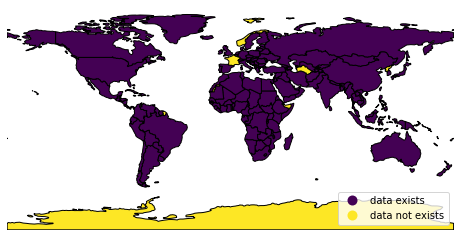

In [30]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world_is_in_data = world[world["iso_a3"].isin(set(raw_data["iso_code"]))]
world_is_in_data["is_in_data"] = "data exists"
world_not_is_in_data = world[~world["iso_a3"].isin(set(raw_data["iso_code"]))]
world_not_is_in_data["is_in_data"] = "data not exists"
world = pd.concat([world_is_in_data, world_not_is_in_data])

gplt.choropleth(world, hue='is_in_data', legend=True)

# Correlation of each data

There seems to be no correlation between "total_cases", "total_deaths", and "stringency_index".

<Figure size 720x576 with 0 Axes>

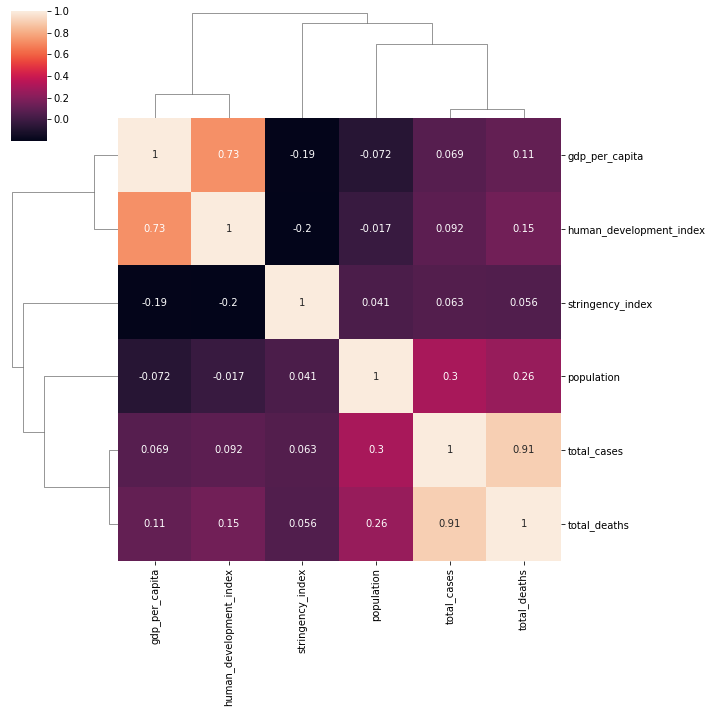

In [31]:
plt.figure(figsize=(10,8))
corr_cols = ["total_cases", "total_deaths", "stringency_index", "population", "gdp_per_capita", "human_development_index"]
sns.clustermap(raw_data[corr_cols].corr(),annot = True)
plt.show()

# Data transition for each month

Let's take a look at how the monthly averages of the following data have shifted.

* total_deaths

* stringency_index

* gdp_per_capita

* human_development_index

We can see that total_deaths is continuously increasing for the United States, Brazil, Mexico, and India. In these countries, there will likely be a greater impact on the economy.

In [32]:
fig = px.line(data_mean, x="month", y="total_deaths", color="iso_code", 
              title='total_deaths',
              template="simple_white")
fig.show()

We can see that stringency_index is rising in each country toward around April, but it has been constant or falling since then.

In [33]:
fig = px.line(data_mean, x="date", y="stringency_index", color="iso_code", 
              title='stringency_index',
              template="simple_white")
fig.show()

gdp_per_capita is constant over a period of time.

In [35]:
fig = px.line(data_mean, x="month", y="gdp_per_capita", color="iso_code", 
              title='gdp_per_capita',
              template="simple_white")
fig.show()

human_development_index is also constant over a period of time.

# Data visualization on a world map

Let's display the data for each month on a world map and see how the data transitioned.

In [24]:
def plot_world_data(df, year, month):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    df_query = df.query(f'year == {year} and month == {month}')
    world = pd.merge(world, df_query, left_on='iso_a3', right_on='iso_code')
    
    fig, axs = plt.subplots(2, 2, figsize=(20,10))
    
    fig.suptitle(f'Data at {year}/{month}', fontsize=20)
    g00 = gplt.choropleth(world, hue='total_deaths', legend=True, norm=NORM_TOTAL_DEATH, ax=axs[0][0])
    g00.set_title(f"total_deaths")
    g10 = gplt.choropleth(world, hue='stringency_index', legend=True, norm=NORM_STRINGENCY, ax=axs[1][0])
    g10.set_title(f"stringency_index")
    g01 = gplt.choropleth(world, hue='gdp_per_capita', legend=True, norm=NORM_GDP_PER_CAPITA, ax=axs[0][1])
    g01.set_title(f"gdp_per_capita")
    g11 = gplt.choropleth(world, hue='human_development_index', legend=True, norm=NORM_HUMAN_DEVELOPMENT, ax=axs[1][1])
    g11.set_title(f"human_development_index")

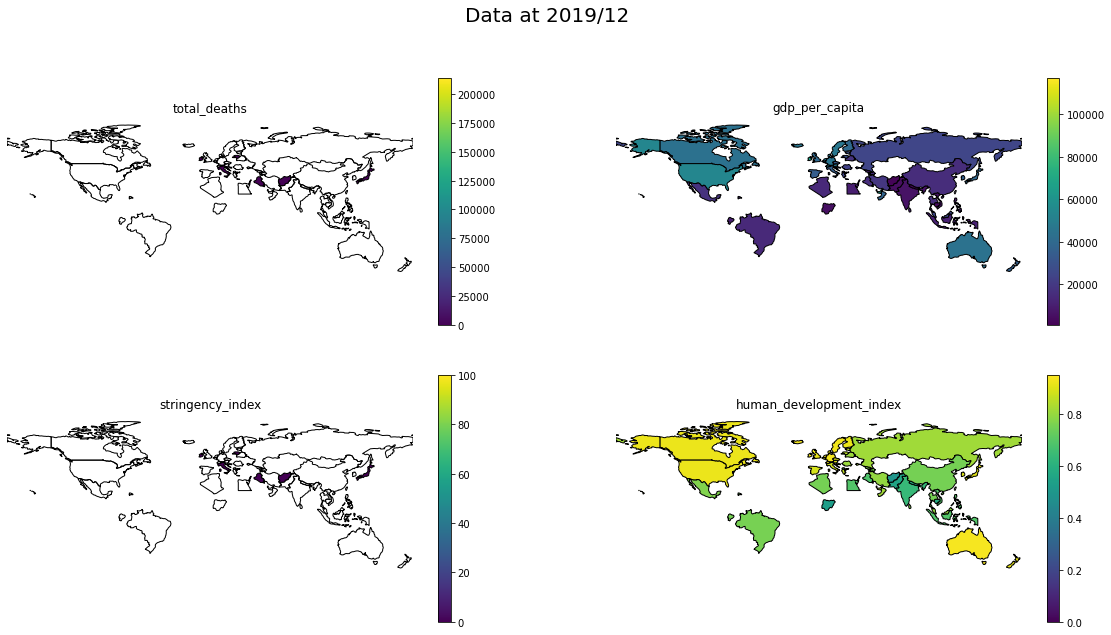

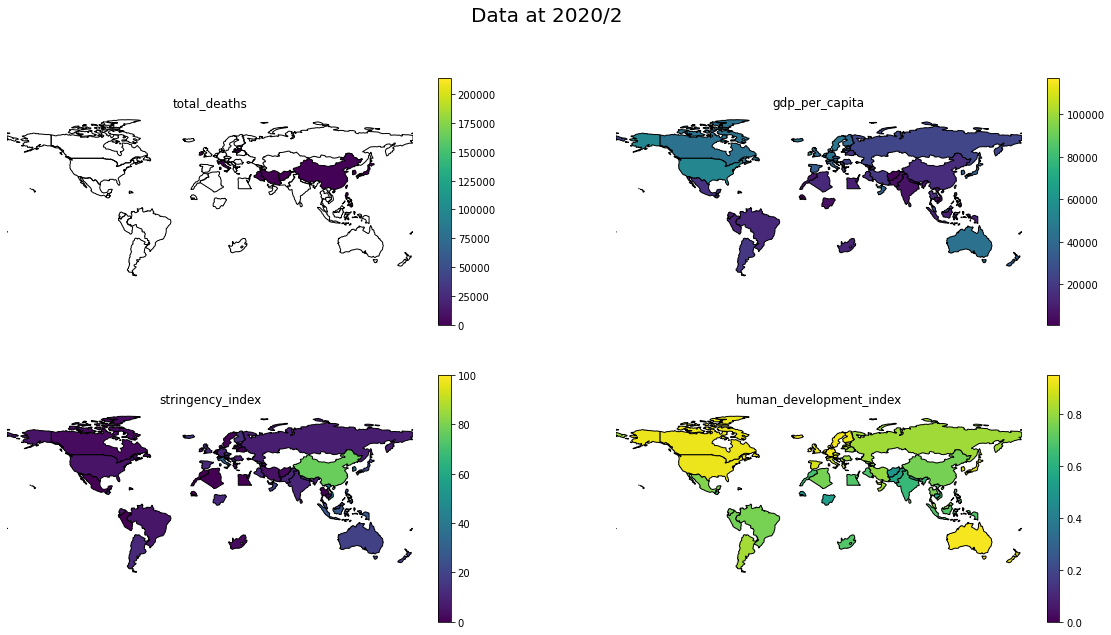

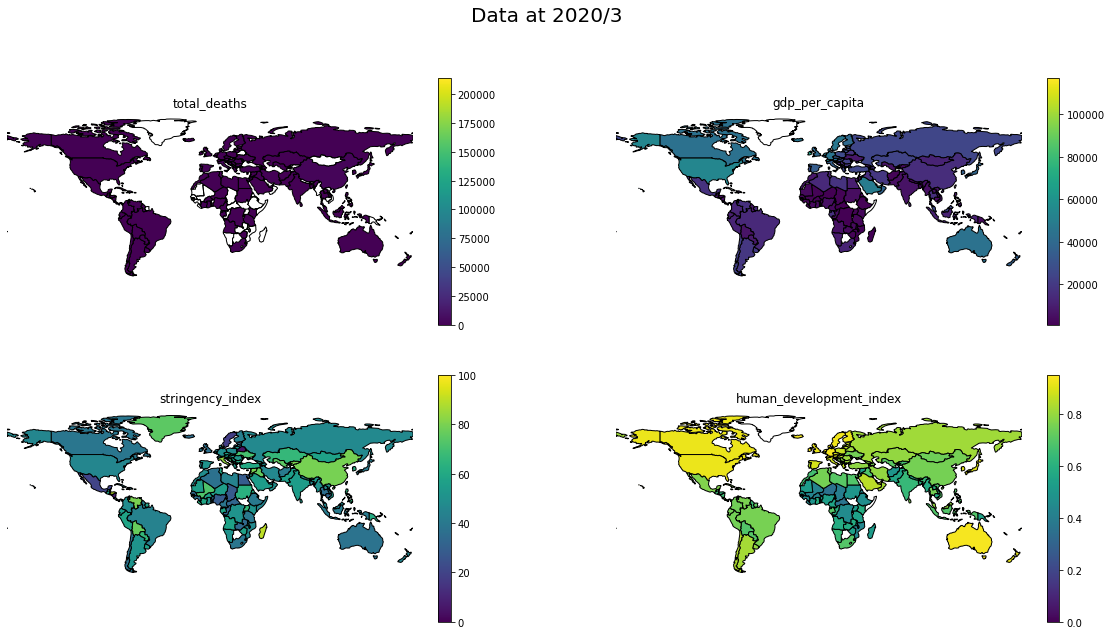

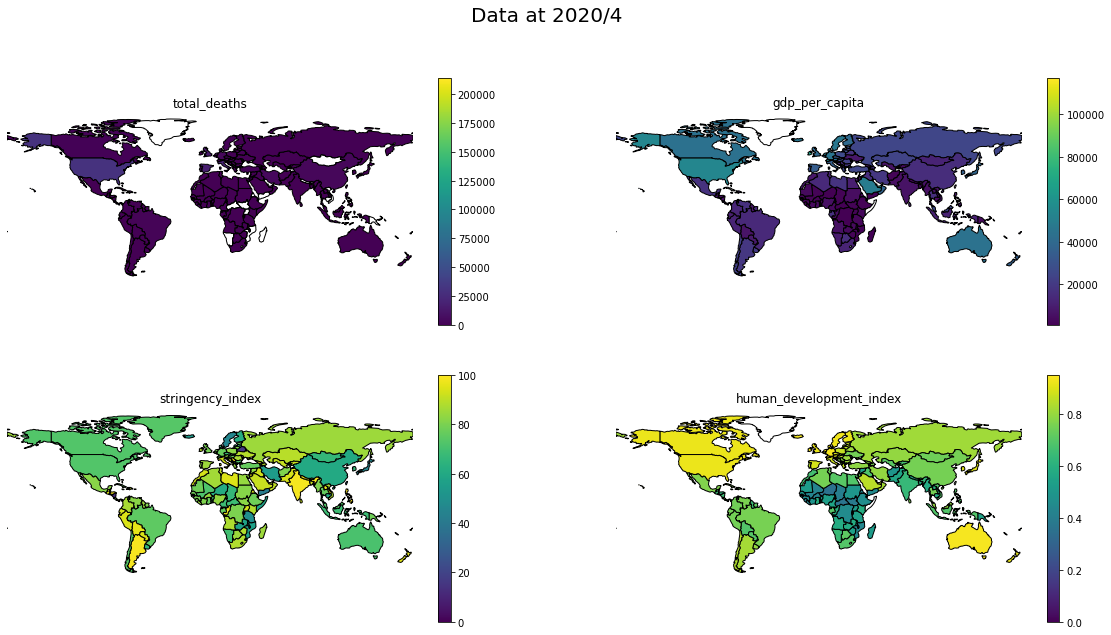

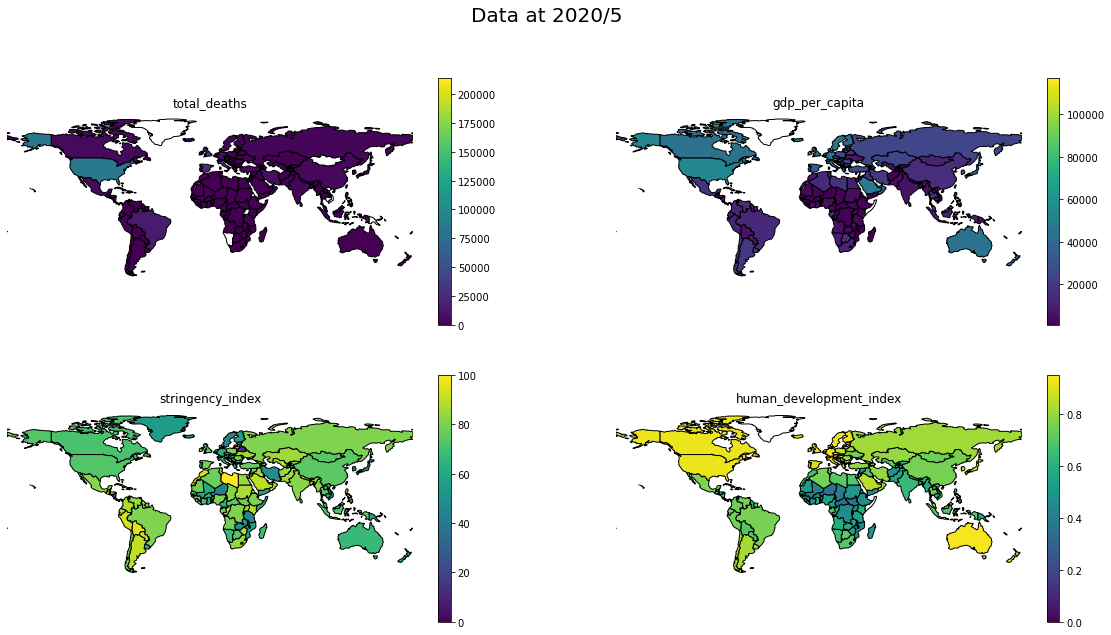

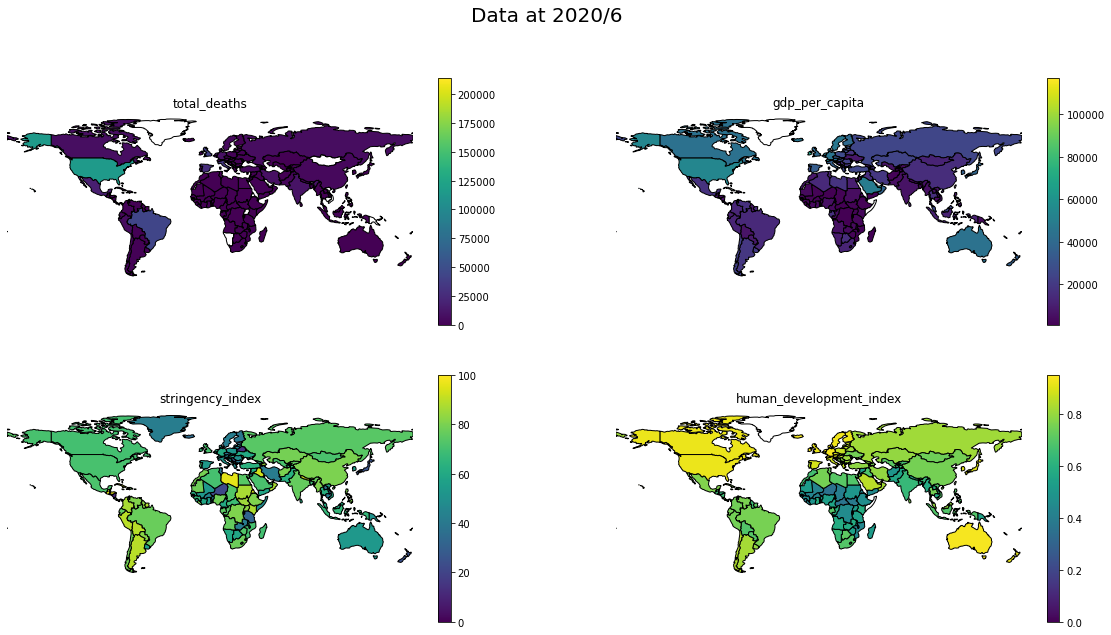

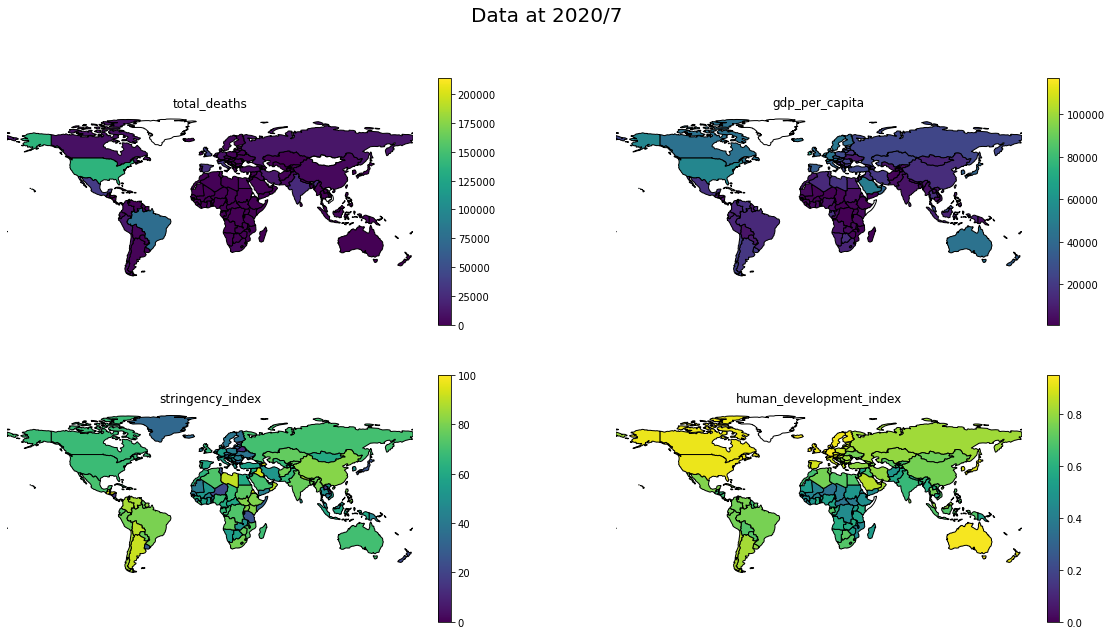

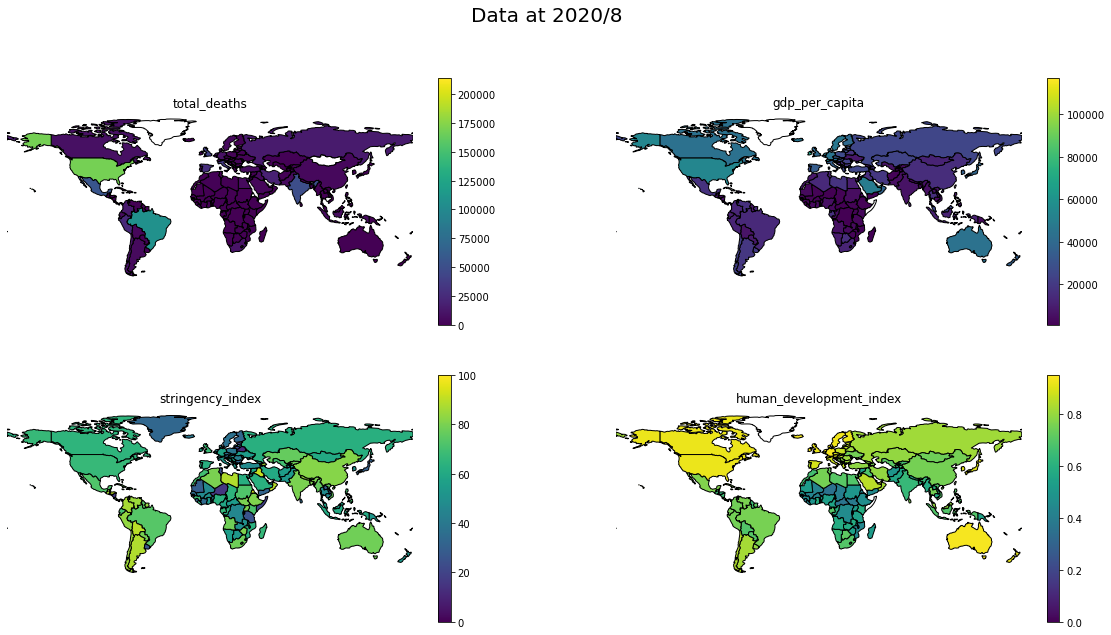

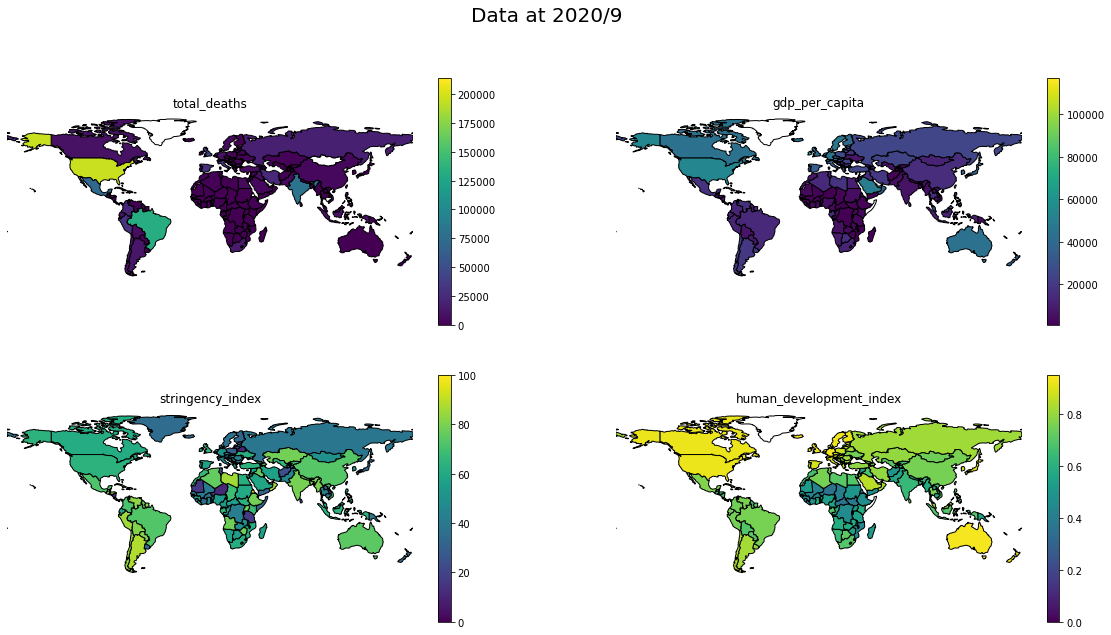

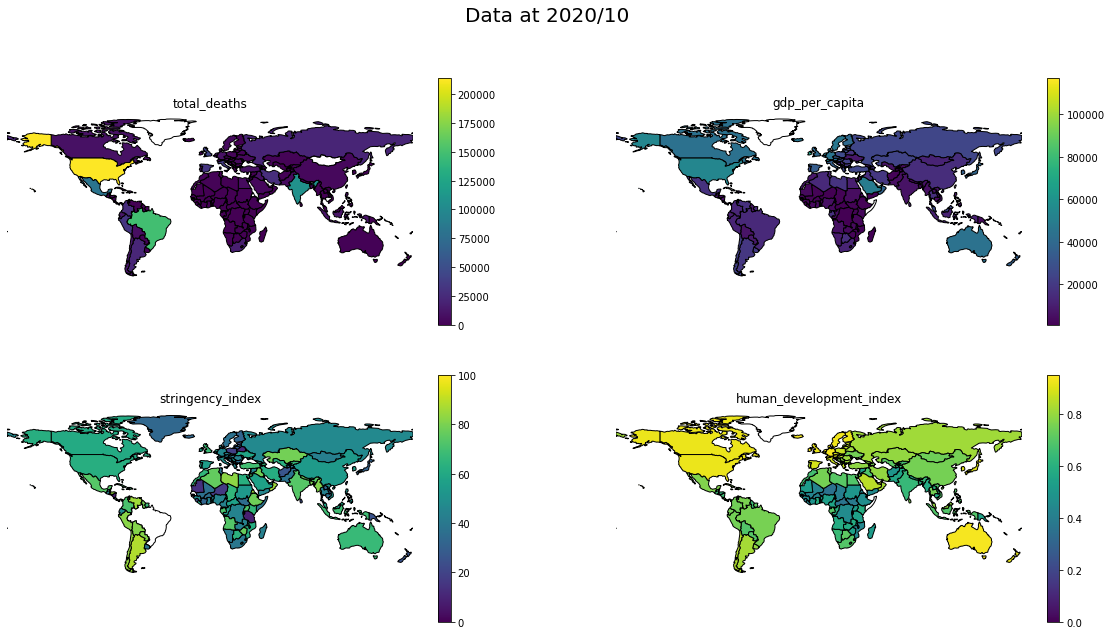

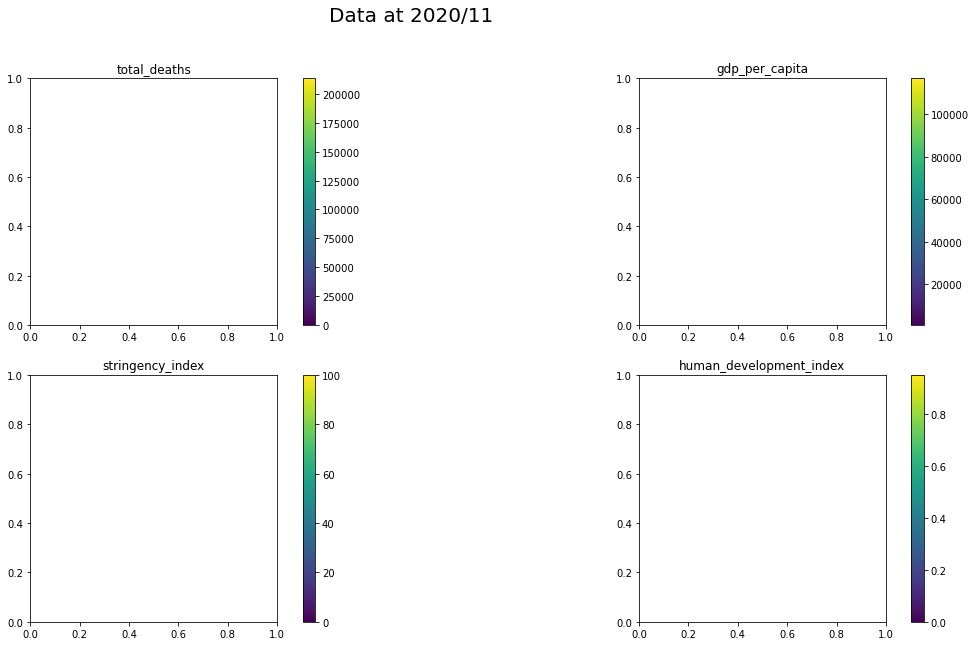

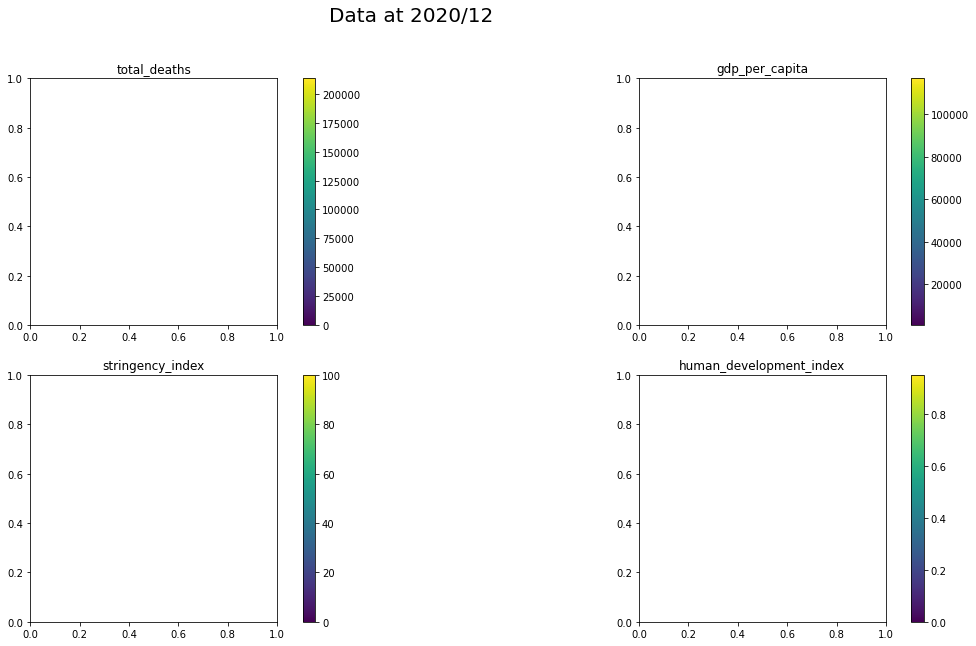

In [38]:
time_points = [(2019, 12), (2020, 2), (2020, 3), (2020, 4), (2020, 5), (2020, 6), (2020, 7), (2020, 8), (2020, 9),(2020,10), (2020,11),(2020,12)]
for time_point in time_points:
    year, month = time_point
    plot_world_data(data_mean, year, month)